# Parameter Control and Adaptation

Evolutionary algorithms have many different parameters and implementation choices. There are qualitative parameters in the design of an algorithm (e.g., what representation, what recombination operators, what selection operators, etc.) and quantitative parameters (e.g., mutation rate, crossover rate, selection bias, population size, etc.) So far, we used intuition and common default values for many of these parameters. However, parameters can have a large influence on the performance of an algorithm on a particular problem. This chapter looks at how to optimise the selection of parameter values.

## Example Problem: Pairwise Testing

As an example search problem we will consider pairwise testing, a form of combinatorial interaction testing where we want to generate covering arrays of strength 2. The problem is as follows: We are testing a system with _x_ parameters, each parameter can have a different number of parameter values. In order to properly test the system, we would need to check all possible combinations of parameter values, but the combinatorial explosion usually makes this practically impossible. Since most failures are triggered by combinations of only few combinations, the idea of pairwise testing is to try to cover all combinations of values for any pair of 2 parameters, which greatly reduces the number of tests.

Let's assume we have a system with a number of parameters, each with a number of parameters:

In [1]:
parameters = { 0 : ["a", "b", "c", "d", "x"],
               1 : ["d", "e", "f", "g", "x"],
               2 : ["g", "h", "i", "j", "x"],
               3 : ["g", "h", "i", "j", "x"],
               4 : ["g", "h", "i", "j", "x"],
               5 : ["j", "k", "l", "m", "x"]}

The aim of our optimisation problem is to produce a set of tests that covers as many as possible combinations of parameter-value pairs, at the same time we don't want too many test cases. In principle we could make this a multi-objective problem and optimise for size and coverage, but to simplify our examples we will just assume a fixed number of tests, and try to cover as many as possible pairs with that exact number of tests:

In [2]:
num_tests = 25

We'll use a very basic genetic algorithm to solve the problem. As usual, some imports:

In [3]:
import random
import pprint
import math
import copy
import matplotlib.pyplot as plt

We'll use our wrapper class because we will be cachine some values later on:

In [4]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

A test case is a list of values, one for each parameter of our system:

In [5]:
def get_random_test():
    num_params = len(parameters)
    test = []
    for p in range(num_params):
        test.append(random.choice(parameters[p]))
    return test

An individual of our search is a list of `num_tests` of such tests:

In [6]:
def get_random_solution():
    solution = L([])
    for test in range(num_tests):
        solution.append(get_random_test())
    return solution

As a simple (though maybe somewhat computationally inefficient) fitness function we count how many distinct pairs of pairwise parameter-value combinations we are covering by putting them in a set and then counting the size. The larger the set, the more pairs we have covered:

In [7]:
def get_fitness(individual):
    pairs = set()

    for num1 in range(len(parameters) - 1):
        for num2 in range(num1 + 1, len(parameters)):
            for row in individual:
                pairs.add((num1, num2, row[num1], row[num2]))

    return len(pairs)

In previous chapters, the parameters were dispersed throughout the notebooks with some global variables. Since we are focusing on parameters now, we will store them explicitly in a dictionary. Let's set some default values:

In [8]:
configuration = {
    "P_xover": 0.7,
    "P_mutation": 0.07,
    "population_size": 100,
    "tournament_size": 2
}

We are only optimising quantitative parameters, so the operators will be the ones we've used previously, adapted only to make use of our configuration dictionary:

In [9]:
def tournament_selection(population):
    # Make sure the sample isn't larger than the population
    candidates = random.sample(population, min(len(population), configuration["tournament_size"]))
    winner = max(candidates, key=lambda x: get_fitness(x))    
                
    return winner

We'll use single-point crossover for tests, and just need to make sure to preserve our wrapper classes:

In [10]:
def crossover(parent1, parent2):
    pos = random.randint(1, len(parent1))

    offspring1 = L(copy.deepcopy(parent1[:pos] + parent2[pos:]))
    offspring2 = L(copy.deepcopy(parent2[:pos] + parent1[pos:]))

    return offspring1, offspring2

In the past we dynamically set the mutation rate based on the size of individuals. To make it easier to evaluate the effects of the mutation rate parameter, we will now set it explicitly. Each parameter in our list of tests is replaced with a different parameter value with that probability. We'll pass in the probability as a parameter rather and read the value of the configuration dictionary outside the operator.

In [11]:
def mutate(individual, P_mutate):
    mutated = L(copy.deepcopy(individual))
    for num_row in range(len(mutated)):
        for num_col in range(len(parameters)):
            if random.random() < P_mutate:
                choice = parameters[num_col][:]
                choice.remove(mutated[num_row][num_col])
                mutated[num_row][num_col] = random.choice(choice)

    return mutated

The reproduction-related probabilities are considered during a step of our algorithm:

In [12]:
def evolution_step(population):
    new_population = []
    
    while len(new_population) < len(population):
        parent1 = selection(population)
        parent2 = selection(population)

        if random.random() < configuration["P_xover"]:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = mutate(offspring1, configuration["P_mutation"])
        offspring2 = mutate(offspring2, configuration["P_mutation"])

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

Finally, we'll just set some parameters and global variables for our experiments, such as the list of fitness values to observe what happened, and the number of fitness evaluations as our stopping criterion:

In [13]:
max_evaluations = 10000
selection = tournament_selection
fitness_values = []

The algorithm itself should by now be well known:

In [14]:
def ga():
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)
    print(f"Initial population, best fitness: {best_fitness}")

    iteration = 0
    while iteration < (max_evaluations / configuration["population_size"]):
        fitness_values.append(best_fitness)
        iteration += 1
        evolution_step(population)
        current_best = max(population, key=lambda k: get_fitness(k))
        current_fitness = get_fitness(current_best)
        if current_fitness > best_fitness:
            print(f"Iteration {iteration}, best fitness: {best_fitness}")
            best_individual = copy.deepcopy(current_best)
            best_fitness = current_fitness

    fitness_values.append(best_fitness)
    return best_individual

We can now run our algorithm and look at the resulting test suite:

In [15]:
fitness_values = []
solution = ga()

# Pretty print output
pp = pprint.PrettyPrinter(depth=6)
solution.sort()
pp.pprint(solution)
print(len(solution))

Initial population, best fitness: 264
Iteration 8, best fitness: 264
Iteration 13, best fitness: 267
Iteration 17, best fitness: 269
Iteration 18, best fitness: 271
[['a', 'e', 'h', 'j', 'j', 'm'],
 ['a', 'f', 'g', 'x', 'x', 'j'],
 ['a', 'g', 'i', 'j', 'j', 'k'],
 ['a', 'g', 'j', 'i', 'g', 'x'],
 ['b', 'd', 'j', 'g', 'g', 'j'],
 ['b', 'd', 'j', 'j', 'h', 'x'],
 ['b', 'e', 'x', 'h', 'h', 'k'],
 ['b', 'f', 'i', 'g', 'i', 'k'],
 ['c', 'd', 'x', 'i', 'x', 'j'],
 ['c', 'e', 'j', 'g', 'x', 'x'],
 ['c', 'f', 'h', 'x', 'g', 'l'],
 ['c', 'g', 'x', 'j', 'x', 'l'],
 ['c', 'x', 'h', 'j', 'i', 'm'],
 ['d', 'd', 'j', 'i', 'j', 'j'],
 ['d', 'e', 'i', 'i', 'h', 'x'],
 ['d', 'e', 'x', 'i', 'x', 'm'],
 ['d', 'f', 'j', 'g', 'j', 'm'],
 ['d', 'g', 'i', 'j', 'x', 'j'],
 ['d', 'x', 'g', 'x', 'j', 'm'],
 ['d', 'x', 'h', 'i', 'i', 'k'],
 ['d', 'x', 'j', 'h', 'i', 'j'],
 ['x', 'd', 'i', 'x', 'i', 'm'],
 ['x', 'e', 'g', 'g', 'h', 'l'],
 ['x', 'f', 'g', 'h', 'i', 'x'],
 ['x', 'g', 'g', 'j', 'h', 'j']]
25


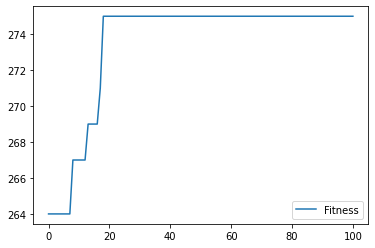

In [16]:
plt.plot(fitness_values, label="Fitness")
plt.legend()

## Parameter Tuning

Tuning refers to a (systematic) process of optimising the values of the parameters of our algorithm. There are many considerations when doing so: Which parameters, and which levels? We can't look at all possible values for our parameters, so we will have to consider some relevant values. For example, let's consider the following parameters and their possible values:

In [17]:
search_parameters = {
    "population_size": [5, 37, 52, 67, 99],
    "tournament_size": [1, 2, 3, 4, 5],
    "P_mutation": [0.01, 0.34, 0.5, 0.65, 0.99],
    "P_xover": [0.01, 0.34, 0.5, 0.65, 0.99]
}

To find the best configuration based on these options, one way is to produce a factorial design, i.e., a combination of all possible values (very similar to the example problem we are solving with search in this chapter!) Let's define a function that produces such a factorial design:

In [18]:
def get_factorial_design(search_parameters):
    configurations = [{}]
    
    for parameter in search_parameters.keys():
        new_configurations = []
        for configuration in configurations:
            for option in range(len(search_parameters[parameter])):
                cp = configuration.copy()
                cp[parameter] = search_parameters[parameter][option]
                new_configurations.append(cp)
            
        configurations = new_configurations
    
    return configurations

For our choice of parameters and values, this is the resulting factorial design:

In [19]:
# This produces a loooong list...
# get_factorial_design(search_parameters)

In [20]:
len(get_factorial_design(search_parameters))

625

In order to find the best parameter setting, we would have to run the search on some example problems for each of these configurations. That would take very long, so one option is to produce a fractional factorial design where we omit or restrict certain combinations. Let's simply reduce the value choices to 2 per parameter:

In [21]:
search_parameters = {
    "population_size": [20, 100],
    "tournament_size": [1, 3],
    "P_mutation": [0.01, 0.5],
    "P_xover": [0.0, 0.7]
}

In [22]:
len(get_factorial_design(search_parameters))

16

In order to evaluate how well each of the configurations performs, we need to define what _performance_ actually means. A simple measurement of performance is given be the fitness value of the resulting solution. However, since the algorithm is randomised, we need to apply it repeatedly. Furthermore, we need to choose which problem instances to evaluate the algorithm on. To keep things simple, we will only consider the specific problem listed earlier, and we'll measure the performance as the average of the best fitness values for a number of repetitions:

In [23]:
from IPython.utils import io
def get_performance(config):
    global max_evaluations
    results = []
    repetitions = 4 # Should be more, but to accelerate the notebook...
    old_evaluations = max_evaluations
    max_evaluations = 3000 # Should be more, but to accelerate the notebook...
    for i in range(repetitions):
        fitness_values = []
        configuration.update(config)
        with io.capture_output() as captured: 
            result = ga()
            fitness = get_fitness(result)
        results.append(fitness)
    max_evaluations = old_evaluations
    return sum(results)/len(results)

Now we just have to consider each configuration of our factorial design and measure the performance. The best configuration is the one with the best performance:

In [24]:
best_config = None
best_performance = 0
#max_evaluations = 10000 # Limit number of fitness evaluations so we don't have to wait too long
for config in get_factorial_design(search_parameters):
    print(f"Current configuration: {config}")
    performance = get_performance(config)
    print(f"Performance: {performance}")
    if performance > best_performance:
        best_config = config
        best_performance = performance

print(f"Chosen best configuration: {best_config}")
configuration.update(best_config)

Current configuration: {'population_size': 20, 'tournament_size': 1, 'P_mutation': 0.01, 'P_xover': 0.0}
Performance: 262.25
Current configuration: {'population_size': 20, 'tournament_size': 1, 'P_mutation': 0.01, 'P_xover': 0.7}
Performance: 265.5
Current configuration: {'population_size': 20, 'tournament_size': 1, 'P_mutation': 0.5, 'P_xover': 0.0}
Performance: 269.25
Current configuration: {'population_size': 20, 'tournament_size': 1, 'P_mutation': 0.5, 'P_xover': 0.7}
Performance: 268.0
Current configuration: {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.0}
Performance: 301.5
Current configuration: {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7}
Performance: 306.25
Current configuration: {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.5, 'P_xover': 0.0}
Performance: 269.0
Current configuration: {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.5, 'P_xover': 0.7}
Performance: 268.0
Current c

Finding vectors of parameter values is a complex optimisation task. Our performance function defines a _utility landscape_ -- an abstract landscape where the locations are the parameter vectors of an EA and the height reflects the utility (performance). Thus, technically we can treat our tuning problem as a search problem. To do so, we'll define range limits for the parameters we are optimising:

In [25]:
search_parameter_ranges = {
    "population_size": [1, 100],
    "tournament_size": [1, 5],
    "P_mutation": [0.0, 0.2],
    "P_xover": [0.0, 1.0]
}

In order to apply meta-heuristic search to the problem of optimising the parameters of a meta-heuristic search algorithm, we need to define a representation, which is a parameter vector. We'll define a helper function that gives us a random value for a chosen parameter, using the range limits defined above:

In [26]:
def get_random_parameter(parameter_name):
    value = random.uniform(*search_parameter_ranges[parameter_name])
    if type(1) == type(search_parameter_ranges[parameter_name][0]):
        value = int(value)
    return value

An individual of our parameter-search is a dictionary of parameter values:

In [27]:
def get_random_configuration():
    config = {}
    for param in search_parameter_ranges.keys():
        config[param] = get_random_parameter(param)
    return config

In [28]:
get_random_configuration()

{'population_size': 37,
 'tournament_size': 3,
 'P_mutation': 0.029296616266056265,
 'P_xover': 0.82736810892516}

A very basic mutation of parameter dictionaries is to replace individual parameters with different values.

In [29]:
def mutate_configuration(config):
    copy = config.copy()
    P_mutate = 1/len(copy)
    while copy == config:
        for key in copy.keys():
            if random.random() < P_mutate:
                copy[key] = get_random_parameter(key)

    return copy

Technically, we can use any search algorithm for this optimisation problem. However, measuring fitness requires running our `get_performance` function, which is expensive. Thus, some algorithms are better suited than others. One popular algorithm in practice is _differential evolution_, which we haven't covered yet, so to keep things simple we'll just use a (1+1)EA:

In [30]:
def oneplusone():
    current = best_config #get_random_configuration()
    fitness = get_performance(current)
    iteration = 0
    print(f"Iteration {iteration}: Fitness {fitness} - {current}")

    while iteration < max_steps:
        iteration += 1
        candidate = mutate_configuration(current)
        candidate_fitness = get_performance(candidate)
        print(f"Iteration {iteration}: Fitness {candidate_fitness} - {candidate}")
        if candidate_fitness >= fitness:
            current = candidate
            fitness = candidate_fitness
        fitness_values.append(fitness)

    return current

In [31]:
max_steps = 20
oneplusone()

Iteration 0: Fitness 306.25 - {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7}
Iteration 1: Fitness 305.5 - {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.24008455292027076}
Iteration 2: Fitness 305.5 - {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7340140610503703}
Iteration 3: Fitness 282.25 - {'population_size': 27, 'tournament_size': 3, 'P_mutation': 0.03561303240917313, 'P_xover': 0.7}
Iteration 4: Fitness 295.25 - {'population_size': 87, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7}
Iteration 5: Fitness 307.75 - {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.009117409341805006, 'P_xover': 0.7}
Iteration 6: Fitness 302.25 - {'population_size': 41, 'tournament_size': 3, 'P_mutation': 0.009117409341805006, 'P_xover': 0.2118769773504885}
Iteration 7: Fitness 305.0 - {'population_size': 3, 'tournament_size': 4, 'P_mutation': 0.009117409341805006, 'P_xover': 0.7}

{'population_size': 20,
 'tournament_size': 4,
 'P_mutation': 0.009117409341805006,
 'P_xover': 0.4094810447838457}

To reduce the enormous costs of fitness evaluations in this search, the _response surface methodology_ systematically samples the utility space, creates a regression model that predicts the utility for parameter values, and then uses this regression model as a surrogate for querying the performance.

As an alternative to a full factorial design, the response surface methodology is often performed using a _central composite design_. For the central composite design we obtain five levels for each parameter: {0, 1, −1, α, −α}.

The design consists of three matrices:
- A factorial design with two levels for each factor (1, -1)
- A set of center points (0)
- A set of axial points, configurations identical to the centre points except for one factor that is varied with values below and above the median (α, −α).

(The choice of 1, -1, α, -α is actually more complicated, but out of scope for this notebook)

For example, assume we have derived the following levels (-α, -1, 0, 1, α) for our factors:

In [32]:
search_parameters = {
    "population_size": [5, 37, 52, 67, 99],
    "tournament_size": [1, 2, 3, 4, 5],
#    "P_mutation": [0.01, 0.1, 0.15, 0.2, 0.3],
    "P_mutation": [0.005, 0.01, 0.05, 0.1, 0.2],
    "P_xover": [0.01, 0.34, 0.5, 0.65, 0.99]
}

We will define helper functions that produce the three component matrices:

In [33]:
def get_factorial_for(search_parameters, options = [1, 3]):
    configurations = [{}]
    
    for parameter in search_parameters.keys():
        new_configurations = []
        for configuration in configurations:
            for option in options:
                cp = configuration.copy()
                cp[parameter] = search_parameters[parameter][option]
                new_configurations.append(cp)
            
        configurations = new_configurations
    
    return configurations

In [34]:
get_factorial_for(search_parameters)

[{'population_size': 37,
  'tournament_size': 2,
  'P_mutation': 0.01,
  'P_xover': 0.34},
 {'population_size': 37,
  'tournament_size': 2,
  'P_mutation': 0.01,
  'P_xover': 0.65},
 {'population_size': 37,
  'tournament_size': 2,
  'P_mutation': 0.1,
  'P_xover': 0.34},
 {'population_size': 37,
  'tournament_size': 2,
  'P_mutation': 0.1,
  'P_xover': 0.65},
 {'population_size': 37,
  'tournament_size': 4,
  'P_mutation': 0.01,
  'P_xover': 0.34},
 {'population_size': 37,
  'tournament_size': 4,
  'P_mutation': 0.01,
  'P_xover': 0.65},
 {'population_size': 37,
  'tournament_size': 4,
  'P_mutation': 0.1,
  'P_xover': 0.34},
 {'population_size': 37,
  'tournament_size': 4,
  'P_mutation': 0.1,
  'P_xover': 0.65},
 {'population_size': 67,
  'tournament_size': 2,
  'P_mutation': 0.01,
  'P_xover': 0.34},
 {'population_size': 67,
  'tournament_size': 2,
  'P_mutation': 0.01,
  'P_xover': 0.65},
 {'population_size': 67,
  'tournament_size': 2,
  'P_mutation': 0.1,
  'P_xover': 0.34},
 {'p

In [35]:
def get_center_point(parameters, center = 2):
    configuration = {}
    for parameter in parameters.keys():
        configuration[parameter] = parameters[parameter][center]
    return configuration

In [36]:
get_center_point(search_parameters)

{'population_size': 52,
 'tournament_size': 3,
 'P_mutation': 0.05,
 'P_xover': 0.5}

In [37]:
def get_axial_points(parameters, axial_points = [0, 4]):
    configurations = []
    
    for parameter in parameters.keys():
        for axial_point in axial_points:
            configuration = get_center_point(parameters)
            configuration[parameter] = parameters[parameter][axial_point]
            configurations.append(configuration)
    return configurations

In [38]:
get_axial_points(search_parameters)

[{'population_size': 5,
  'tournament_size': 3,
  'P_mutation': 0.05,
  'P_xover': 0.5},
 {'population_size': 99,
  'tournament_size': 3,
  'P_mutation': 0.05,
  'P_xover': 0.5},
 {'population_size': 52,
  'tournament_size': 1,
  'P_mutation': 0.05,
  'P_xover': 0.5},
 {'population_size': 52,
  'tournament_size': 5,
  'P_mutation': 0.05,
  'P_xover': 0.5},
 {'population_size': 52,
  'tournament_size': 3,
  'P_mutation': 0.005,
  'P_xover': 0.5},
 {'population_size': 52,
  'tournament_size': 3,
  'P_mutation': 0.2,
  'P_xover': 0.5},
 {'population_size': 52,
  'tournament_size': 3,
  'P_mutation': 0.05,
  'P_xover': 0.01},
 {'population_size': 52,
  'tournament_size': 3,
  'P_mutation': 0.05,
  'P_xover': 0.99}]

The full central composite design now consists of all three of these:

In [39]:
configurations = get_factorial_for(search_parameters) + \
    [ get_center_point(search_parameters) ] + \
    get_axial_points(search_parameters)

In [40]:
len(configurations)

25

Now we need some patience while we determined the performance for each of these configurations:

In [41]:
responses = []
max_evaluations = 10000
for config in configurations:
    r = get_performance(config)
    config["performance"] = r
    print(config)
    responses.append(r)

{'population_size': 37, 'tournament_size': 2, 'P_mutation': 0.01, 'P_xover': 0.34, 'performance': 293.5}
{'population_size': 37, 'tournament_size': 2, 'P_mutation': 0.01, 'P_xover': 0.65, 'performance': 293.25}
{'population_size': 37, 'tournament_size': 2, 'P_mutation': 0.1, 'P_xover': 0.34, 'performance': 271.75}
{'population_size': 37, 'tournament_size': 2, 'P_mutation': 0.1, 'P_xover': 0.65, 'performance': 270.5}
{'population_size': 37, 'tournament_size': 4, 'P_mutation': 0.01, 'P_xover': 0.34, 'performance': 309.75}
{'population_size': 37, 'tournament_size': 4, 'P_mutation': 0.01, 'P_xover': 0.65, 'performance': 310.25}
{'population_size': 37, 'tournament_size': 4, 'P_mutation': 0.1, 'P_xover': 0.34, 'performance': 277.25}
{'population_size': 37, 'tournament_size': 4, 'P_mutation': 0.1, 'P_xover': 0.65, 'performance': 274.25}
{'population_size': 67, 'tournament_size': 2, 'P_mutation': 0.01, 'P_xover': 0.34, 'performance': 290.0}
{'population_size': 67, 'tournament_size': 2, 'P_muta

The next step is to create a regression model that predicts the performance of any given combination of parameter values. We'll cut this short and simply throw our data at a linear regression model, and doing this properly and checking the fit of the model are left as an exercise.

In [42]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [43]:
model = LinearRegression()

In [44]:
df = pd.DataFrame(configurations)
y = df['performance']
x = df[['population_size', 'tournament_size', 'P_mutation', 'P_xover']]
# This will need some adjusting...
model.fit(x, y)

LinearRegression()

In [45]:
model.coef_

array([-5.87116488e-02,  4.73958333e+00, -2.19239544e+02, -3.29196387e+00])

We can now take any configuration and query the model. For example, let's query the configuration we determined best with our simplified factorial design initially:

In [46]:
model.predict([list(best_config.values())])

array([294.9918001])

We'll use a (1+1)EA again to do the search, but instead of querying the fitness function, we query the model:

In [47]:
def surrogate_oneplusone():
    current = best_config #get_random_configuration()
    fitness = model.predict([list(current.values())])[0]
    iteration = 0
    print(f"Iteration {iteration}: Fitness {fitness} - {current}")

    while iteration < max_steps:
        iteration += 1
        candidate = mutate_configuration(current)
        candidate_fitness = model.predict([list(candidate.values())])[0]
        if candidate_fitness >= fitness:
            if candidate_fitness > fitness:
                print(f"Iteration {iteration}: Fitness {candidate_fitness} - {candidate}")
                
            current = candidate
            fitness = candidate_fitness
        fitness_values.append(fitness)

    return current

Since querying the model is very cheap compared to measuring the actual performance, we can run many more iterations of the search algorithm.

In [48]:
max_steps = 1000
rsm_config = surrogate_oneplusone()

Iteration 0: Fitness 294.99180010385817 - {'population_size': 20, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7}
Iteration 1: Fitness 295.22664669901906 - {'population_size': 16, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.7}
Iteration 5: Fitness 296.9206901413368 - {'population_size': 16, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.1854003544339563}
Iteration 10: Fitness 297.0254011215683 - {'population_size': 16, 'tournament_size': 3, 'P_mutation': 0.01, 'P_xover': 0.15359229569831567}
Iteration 18: Fitness 298.5945554202296 - {'population_size': 70, 'tournament_size': 4, 'P_mutation': 0.01, 'P_xover': 0.15359229569831567}
Iteration 23: Fitness 298.5994733875793 - {'population_size': 70, 'tournament_size': 4, 'P_mutation': 0.01, 'P_xover': 0.15209836455592018}
Iteration 26: Fitness 300.1846879049153 - {'population_size': 43, 'tournament_size': 4, 'P_mutation': 0.01, 'P_xover': 0.15209836455592018}
Iteration 32: Fitness 300.59566944644683 - {'populatio

In [49]:
rsm_config

{'population_size': 1,
 'tournament_size': 4,
 'P_mutation': 0.0006398523806402823,
 'P_xover': 0.004480397536262837}

Is the optimised configuration really better? Let's find out by comparing against our initial default values.

In [50]:
configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2

fitness_values = []
ga()
# Stretch this by the population size to make plots comparable
default_fitness = [item for item in fitness_values for i in range(configuration['population_size'])]

configuration.update(rsm_config)
fitness_values = []
ga()
# Stretch this by the population size to make plots comparable
tuned_fitness = [item for item in fitness_values for i in range(configuration['population_size'])]


Initial population, best fitness: 256
Iteration 1, best fitness: 256
Iteration 6, best fitness: 261
Iteration 11, best fitness: 268
Iteration 19, best fitness: 269
Iteration 84, best fitness: 271
Initial population, best fitness: 235
Iteration 1, best fitness: 235
Iteration 8, best fitness: 238
Iteration 9, best fitness: 239
Iteration 14, best fitness: 241
Iteration 15, best fitness: 244
Iteration 21, best fitness: 247
Iteration 28, best fitness: 248
Iteration 51, best fitness: 250
Iteration 85, best fitness: 252
Iteration 171, best fitness: 255
Iteration 175, best fitness: 257
Iteration 187, best fitness: 258
Iteration 196, best fitness: 260
Iteration 214, best fitness: 262
Iteration 231, best fitness: 263
Iteration 238, best fitness: 264
Iteration 329, best fitness: 265
Iteration 385, best fitness: 267
Iteration 387, best fitness: 268
Iteration 390, best fitness: 269
Iteration 402, best fitness: 271
Iteration 420, best fitness: 275
Iteration 443, best fitness: 276
Iteration 470, best

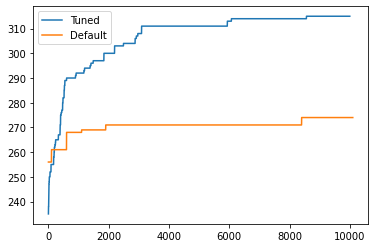

In [51]:
plt.plot(tuned_fitness, label="Tuned")
plt.plot(default_fitness, label="Default")
plt.legend()

## Parameter Control

There's actually something fundamentally missing in the tuning experiments: We did all our tuning on the exact same problem. That's obviously not what we would do in practice: In order to find good parameters we performed search on that problem; once we have found a good set of parameters we know that it is a good set of parameters because we have found a good solution already, so we don't need to run the search again on that problem. What is missing in our experiments is that we would in practice of course do the tuning on several problems, and then hope that these parameters generalise to other, new problems.

A further limitation of parameter tuning is that it tries to select a good set of parameter values, but these parameters remain constant throughout the search. However, different phases of the search may benefit from different parameter values. For example, during initial phases of the search we may want to put more focus on exploration, thus using higher mutation rates than in later phases (like we saw with the MIO algorithm). Thus, a basic approach to control parameters is to make the parameter values dependent on the phase of the search:

In [52]:
def calculate_probability(size, iteration, max_iterations):
    return math.pow(4 + (size - 2)/(max_iterations - 1) * iteration, -1)

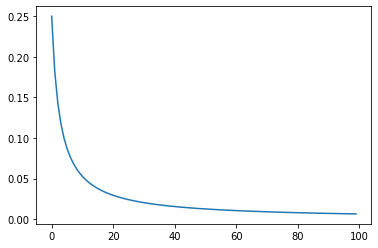

In [53]:
mutation_values = [calculate_probability(num_tests*len(parameters), x, 100) for x in range(100)]
plt.plot(mutation_values)

We'll now create a version of the genetic algorithm which doesn't use the mutation rate from our configuration dictionary, but derives it using our probability function:

In [54]:
def controlled_evolution_step(population, P_mutation):
    new_population = []
    
    while len(new_population) < len(population):
        parent1 = selection(population)
        parent2 = selection(population)

        if random.random() < configuration["P_xover"]:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = mutate(offspring1, P_mutation)
        offspring2 = mutate(offspring2, P_mutation)

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

In [55]:
mutation_values = []
def controlled_ga():
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)
    print(f"Initial population, best fitness: {best_fitness}")

    iteration = 0
    max_iterations = (max_evaluations / configuration["population_size"])
    while iteration < max_iterations:
        fitness_values.append(best_fitness)
        P_mutation = calculate_probability(num_tests * len(parameters), iteration, max_iterations)
        mutation_values.append(P_mutation)
        iteration += 1
        controlled_evolution_step(population, P_mutation)
        current_best = max(population, key=lambda k: get_fitness(k))
        current_fitness = get_fitness(current_best)
        if current_fitness > best_fitness:
            print(f"Iteration {iteration}, best fitness: {best_fitness}")
            best_individual = copy.deepcopy(current_best)
            best_fitness = current_fitness

    fitness_values.append(best_fitness)
    return best_individual

As point of reference, we will compare against our initial default values again:

In [56]:
fitness_values = []
mutation_values = []
max_evaluations = 10000

configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2

controlled_ga()
controlled_fitness = fitness_values

fitness_values = []
ga()

Initial population, best fitness: 260
Iteration 1, best fitness: 260
Iteration 2, best fitness: 261
Iteration 9, best fitness: 265
Iteration 17, best fitness: 267
Iteration 29, best fitness: 271
Iteration 35, best fitness: 272
Iteration 36, best fitness: 274
Iteration 39, best fitness: 275
Iteration 40, best fitness: 277
Iteration 44, best fitness: 278
Iteration 49, best fitness: 279
Iteration 63, best fitness: 283
Iteration 65, best fitness: 284
Iteration 69, best fitness: 285
Iteration 73, best fitness: 290
Iteration 84, best fitness: 292
Iteration 97, best fitness: 293
Initial population, best fitness: 263
Iteration 3, best fitness: 263
Iteration 4, best fitness: 264
Iteration 25, best fitness: 270
Iteration 26, best fitness: 271
Iteration 44, best fitness: 272


[['x', 'f', 'g', 'i', 'j', 'j'],
 ['c', 'f', 'h', 'h', 'g', 'x'],
 ['c', 'd', 'j', 'i', 'g', 'x'],
 ['a', 'x', 'x', 'i', 'h', 'k'],
 ['b', 'e', 'h', 'h', 'j', 'j'],
 ['d', 'd', 'i', 'g', 'h', 'l'],
 ['d', 'd', 'g', 'j', 'g', 'k'],
 ['x', 'g', 'g', 'x', 'i', 'x'],
 ['a', 'f', 'j', 'x', 'j', 'l'],
 ['b', 'd', 'h', 'g', 'x', 'x'],
 ['a', 'e', 'g', 'j', 'x', 'l'],
 ['b', 'f', 'i', 'j', 'i', 'x'],
 ['c', 'g', 'i', 'i', 'g', 'l'],
 ['d', 'f', 'x', 'h', 'x', 'm'],
 ['c', 'e', 'g', 'i', 'x', 'm'],
 ['a', 'g', 'g', 'h', 'i', 'l'],
 ['d', 'f', 'j', 'j', 'j', 'm'],
 ['x', 'g', 'x', 'x', 'g', 'm'],
 ['b', 'g', 'j', 'i', 'x', 'l'],
 ['a', 'd', 'j', 'h', 'x', 'j'],
 ['x', 'e', 'x', 'x', 'h', 'x'],
 ['x', 'x', 'j', 'g', 'i', 'k'],
 ['d', 'x', 'h', 'j', 'h', 'j'],
 ['a', 'd', 'h', 'x', 'j', 'm'],
 ['x', 'e', 'x', 'i', 'j', 'x']]

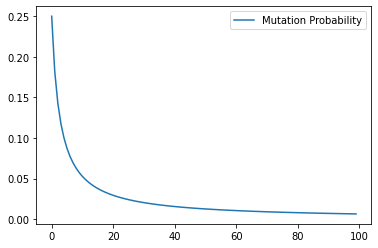

In [57]:
plt.plot(mutation_values, label="Mutation Probability")
plt.legend()

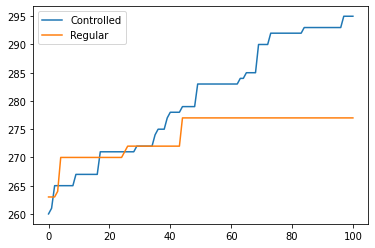

In [58]:
plt.plot(controlled_fitness, label="Controlled")
plt.plot(fitness_values, label="Regular")
plt.legend()

## Adaptive Evolutionary Algorithms

The function that we used to control the mutation rate depends only on the phase of the search, but does not consider how the search is performing at any particular point in time. The idea of _adaptive_ parameter control is to adjust parameters based on how well the search is going. As a basic example, if mutation leads to more fitness improvement than crossover, we may want to increase the probability of doing mutation, and reduce the probability of doing crossover, and vice versa. In order to do this, we need to keep track of the fitness values before and after applying these operators:

In [59]:
def adaptive_crossover(parent1, parent2):
    fitness_pre = get_fitness(parent1) + get_fitness(parent2)
    offspring1, offspring2 = crossover(parent1, parent2)
    fitness_post = get_fitness(offspring1) + get_fitness(offspring2)
    xover_performance.append(fitness_post - fitness_pre)
    return offspring1, offspring2

In [60]:
def adaptive_mutate(individual, P_mutate):
    fitness_pre = get_fitness(individual)
    mutated = mutate(individual, P_mutate)
    fitness_post = get_fitness(mutated)
    mutation_performance.append(fitness_post - fitness_pre)
    return mutated

Note that, technically, we are introducing additional fitness evaluations. However, to some degree these could be avoided (though not all) using some proper caching of fitness values.

In [61]:
mutation_performance = []
xover_performance = []

adaptive_values = []
xover_values = []
mutation_values = []

The individual evolution step is the same as usual, we just need to make sure it uses the correct parameters:

In [62]:
def adaptive_evolution_step(population, mutation_probability, xover_probability):
    new_population = []
    
    while len(new_population) < len(population):
        parent1 = selection(population)
        parent2 = selection(population)

        if random.random() < xover_probability:
            offspring1, offspring2 = adaptive_crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = adaptive_mutate(offspring1, mutation_probability)
        offspring2 = adaptive_mutate(offspring2, mutation_probability)

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

After each step we need to re-evaluate the performance of the operators, and decide whether and how to update the parameters.

In [63]:
def adaptive_ga():
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)
    print(f"Initial population, best fitness: {best_fitness}")

    iteration = 0
    max_iterations = (max_evaluations / configuration["population_size"])
    xover_probability = 0.7
    mutation_probability = 0.07
    delta = 0.01
    
    while iteration < max_iterations:
        mutation_values.append(mutation_probability)
        xover_values.append(xover_probability)
        fitness_values.append(best_fitness)
        iteration += 1
        adaptive_evolution_step(population, mutation_probability, xover_probability)
        
        current_best = max(population, key=lambda k: get_fitness(k))
        current_fitness = get_fitness(current_best)
        if current_fitness > best_fitness:
            print(f"Iteration {iteration}, best fitness: {best_fitness}")
            best_individual = copy.deepcopy(current_best)
            best_fitness = current_fitness
            
        max_mutation = max(mutation_performance) if mutation_performance else 0
        max_xover = max(xover_performance) if xover_performance else 0

        if max_mutation < max_xover:
            xover_probability = min(xover_probability + delta, 1.0)
            mutation_probability = max(mutation_probability - delta, 0.01)
        elif max_xover < max_mutation:
            xover_probability = max(xover_probability - delta, 0.0)
            mutation_probability = min(mutation_probability + delta, 1.0)

        mutation_performance.clear()
        xover_performance.clear()

    fitness_values.append(best_fitness)
    return best_individual

We'll compare how this performs compared to our initial default configuration again.

In [64]:
fitness_values = []
num_mutations = []

configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2

mutation_values = []
xover_values = []
adaptive_ga()
adaptive_fitness = fitness_values

fitness_values = []
ga()

Initial population, best fitness: 259
Iteration 1, best fitness: 259
Iteration 2, best fitness: 261
Iteration 3, best fitness: 262
Iteration 6, best fitness: 264
Iteration 9, best fitness: 266
Iteration 15, best fitness: 270
Iteration 19, best fitness: 272
Iteration 20, best fitness: 273
Iteration 26, best fitness: 275
Iteration 28, best fitness: 276
Iteration 39, best fitness: 279
Iteration 48, best fitness: 280
Iteration 53, best fitness: 285
Iteration 54, best fitness: 286
Iteration 56, best fitness: 287
Iteration 63, best fitness: 288
Iteration 77, best fitness: 295
Iteration 90, best fitness: 298
Iteration 93, best fitness: 299
Iteration 94, best fitness: 300
Initial population, best fitness: 262
Iteration 1, best fitness: 262
Iteration 14, best fitness: 269
Iteration 23, best fitness: 270


[['d', 'e', 'x', 'h', 'j', 'k'],
 ['a', 'd', 'x', 'x', 'h', 'm'],
 ['x', 'd', 'j', 'h', 'h', 'k'],
 ['x', 'g', 'g', 'i', 'x', 'l'],
 ['c', 'f', 'j', 'j', 'x', 'j'],
 ['b', 'e', 'x', 'i', 'j', 'l'],
 ['c', 'd', 'i', 'x', 'g', 'k'],
 ['c', 'f', 'g', 'i', 'i', 'j'],
 ['x', 'e', 'i', 'i', 'h', 'x'],
 ['b', 'f', 'g', 'j', 'i', 'm'],
 ['d', 'g', 'g', 'g', 'x', 'k'],
 ['d', 'e', 'h', 'j', 'i', 'k'],
 ['a', 'f', 'i', 'h', 'x', 'x'],
 ['x', 'd', 'h', 'g', 'h', 'j'],
 ['b', 'f', 'h', 'x', 'x', 'k'],
 ['c', 'x', 'i', 'j', 'j', 'x'],
 ['c', 'x', 'g', 'j', 'j', 'm'],
 ['a', 'x', 'x', 'h', 'g', 'j'],
 ['d', 'x', 'i', 'i', 'i', 'm'],
 ['a', 'e', 'h', 'i', 'g', 'j'],
 ['d', 'g', 'i', 'h', 'h', 'x'],
 ['d', 'f', 'g', 'x', 'j', 'x'],
 ['c', 'e', 'h', 'h', 'h', 'k'],
 ['b', 'g', 'i', 'g', 'g', 'j'],
 ['b', 'x', 'j', 'g', 'i', 'l']]

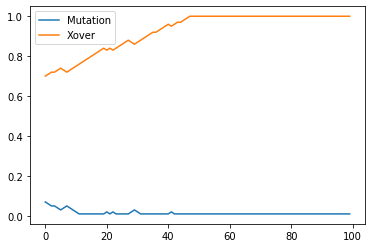

In [65]:
plt.plot(mutation_values, label="Mutation")
plt.plot(xover_values, label="Xover")
plt.legend()

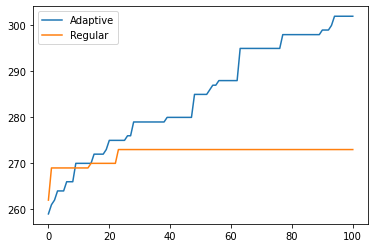

In [66]:
plt.plot(adaptive_fitness, label="Adaptive")
plt.plot(fitness_values, label="Regular")
plt.legend()

## Self-Adaptive Evolutionary Algorithms

Adaptive evolutionary algorithms control some parameters, but thereby introduce new ones (e.g., when and how and how much to update the controlled parameters). What should we set these new parameters to? And should these values be constant, or also adaptive? To avoid this problem altogether we can just let our algorithm decide on its own what values to use, and turn it into a _self-adaptive_ evolutionary algorithm.

We thus add the parameters we want the algorithm to adapt to the representation:

In [67]:
def get_random_solution():
    solution = L([])
    for test in range(num_tests):
        solution.append(get_random_test())

    solution.probabilities = {"P_xover" : random.random(),
                              "P_mutation" : random.random()}
    return solution

When crossing over two individuals, for simplicity we will simply let them inherit their parents' parameter values:

In [68]:
def self_crossover(parent1, parent2):
    offspring1, offspring2 = crossover(parent1, parent2)

    # Make sure copies have the probabilities
    offspring1.probabilities = parent1.probabilities.copy()
    offspring2.probabilities = parent2.probabilities.copy()

    return offspring1, offspring2

Now comes the important bit: When mutating individuals, we not only alter the values (i.e., the test data in our search problem), but also the parameter values. We will add some Gaussian noise to mutate parameters by a little bit, so here's a helper function to keep values in bounds when applying the Gaussian noise:

In [69]:
def crop(value, boundary_min, boundary_max):
    if value > boundary_max:
        return boundary_max
    elif value < boundary_min:
        return boundary_min
    else:
        return value

The actual mutation just calls our usual mutation, and then applies the Gaussian noise -- using the current mutation probability to decide whether or not to mutate each parameter:

In [70]:
def self_mutate(individual, P_mutate):
    
    mutated = mutate(individual, P_mutate)
    mutated.probabilities = individual.probabilities.copy()
    
    for p in mutated.probabilities.keys():
        if random.random() < P_mutate:
            mutated.probabilities[p] = crop(random.gauss(mutated.probabilities[p], 0.05), 0.001, 1)
            
    return mutated

When given two parents, we use the average of the crossover probabilities of the parents as our crossover probability; when mutating an individual, we use its own mutation probability:

In [71]:
def self_evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = selection(population)
        parent2 = selection(population)

        P_xover = (parent1.probabilities["P_xover"] + parent2.probabilities["P_xover"])/2
        if random.random() < P_xover:
            offspring1, offspring2 = self_crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = self_mutate(offspring1, offspring1.probabilities["P_mutation"])
        offspring2 = self_mutate(offspring2, offspring2.probabilities["P_mutation"])

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

The evolutionary algorithm itself is unchanged, but we add some code to keep track of the average parameters in the population so we can look at that after the evolution:

In [72]:
def self_adaptive_ga():
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)
    print(f"Initial population, best fitness: {best_fitness}")

    iteration = 0
    max_iterations = (max_evaluations / configuration["population_size"])
    
    while iteration < max_iterations:
        fitness_values.append(best_fitness)
        mutation_values.append(sum([p.probabilities["P_mutation"] for p in population])/len(population))
        xover_values.append(sum([p.probabilities["P_xover"] for p in population])/len(population))
        iteration += 1
        self_evolution_step(population)
        
        current_best = max(population, key=lambda k: get_fitness(k))
        current_fitness = get_fitness(current_best)
        if current_fitness > best_fitness:
            print(f"Iteration {iteration}, best fitness: {best_fitness}")
            best_individual = copy.deepcopy(current_best)
            best_fitness = current_fitness
            
    fitness_values.append(best_fitness)
    return best_individual

Once again we compare against our initial default values.

In [73]:
max_evaluations = 10000
fitness_values = []
configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2

self_values = []
xover_values = []
mutation_values = []

self_adaptive_ga()
self_values = fitness_values

fitness_values = []
ga()

Initial population, best fitness: 259
Iteration 1, best fitness: 259
Iteration 3, best fitness: 261
Iteration 9, best fitness: 262
Iteration 11, best fitness: 264
Iteration 12, best fitness: 265
Iteration 23, best fitness: 266
Iteration 24, best fitness: 268
Iteration 37, best fitness: 274
Iteration 47, best fitness: 277
Iteration 49, best fitness: 278
Iteration 50, best fitness: 283
Iteration 51, best fitness: 284
Iteration 52, best fitness: 285
Iteration 54, best fitness: 286
Iteration 58, best fitness: 287
Iteration 61, best fitness: 289
Iteration 62, best fitness: 291
Iteration 64, best fitness: 292
Iteration 65, best fitness: 293
Iteration 67, best fitness: 294
Iteration 69, best fitness: 296
Iteration 70, best fitness: 297
Iteration 73, best fitness: 298
Iteration 74, best fitness: 299
Iteration 77, best fitness: 301
Iteration 79, best fitness: 302
Iteration 83, best fitness: 304
Iteration 85, best fitness: 305
Iteration 89, best fitness: 306
Iteration 91, best fitness: 307
Itera

[['x', 'x', 'x', 'x', 'h', 'm'],
 ['x', 'd', 'i', 'i', 'g', 'j'],
 ['c', 'x', 'h', 'g', 'x', 'k'],
 ['a', 'f', 'h', 'g', 'x', 'm'],
 ['c', 'f', 'i', 'x', 'h', 'x'],
 ['d', 'g', 'i', 'g', 'g', 'k'],
 ['b', 'g', 'x', 'x', 'i', 'm'],
 ['d', 'd', 'g', 'x', 'j', 'l'],
 ['x', 'x', 'h', 'i', 'h', 'k'],
 ['a', 'x', 'j', 'h', 'i', 'x'],
 ['b', 'f', 'i', 'h', 'x', 'k'],
 ['a', 'f', 'j', 'x', 'g', 'l'],
 ['c', 'd', 'x', 'h', 'g', 'm'],
 ['d', 'e', 'i', 'g', 'h', 'l'],
 ['x', 'g', 'h', 'i', 'g', 'x'],
 ['c', 'g', 'x', 'h', 'j', 'k'],
 ['a', 'e', 'g', 'x', 'j', 'j'],
 ['x', 'f', 'x', 'h', 'i', 'j'],
 ['b', 'x', 'i', 'i', 'i', 'm'],
 ['d', 'd', 'h', 'j', 'h', 'j'],
 ['b', 'g', 'x', 'g', 'j', 'j'],
 ['a', 'f', 'x', 'j', 'i', 'k'],
 ['d', 'x', 'g', 'i', 'i', 'm'],
 ['c', 'e', 'g', 'h', 'g', 'k'],
 ['x', 'd', 'h', 'j', 'x', 'l']]

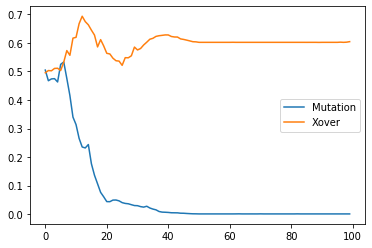

In [74]:
plt.plot(mutation_values, label="Mutation")
plt.plot(xover_values, label="Xover")
plt.legend()

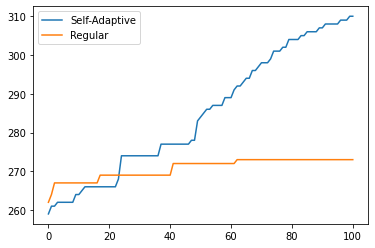

In [75]:
plt.plot(self_values, label="Self-Adaptive")
plt.plot(fitness_values, label="Regular")
plt.legend()

## Generalisation

Throughout this notebook, when we compared algorithms we only looked at individual runs; it's difficult to generalise from an individual run. Furthermore, we always applied the search to the exact same problem. In order to better compare the different configurations, we need to consider _different_ problems.

In [76]:
from IPython.utils import io

def run_times(algorithm, configuration, repetitions):
    global fitness_values
    result = []
    for i in range(repetitions):
        fitness_values = []
        with io.capture_output() as captured: 
            algorithm()
        result.append(fitness_values[-1])
    return result

[Text(1, 0, 'Default'),
 Text(2, 0, 'RSM'),
 Text(3, 0, 'Controlled'),
 Text(4, 0, 'Adaptive'),
 Text(5, 0, 'Self-Adaptive')]

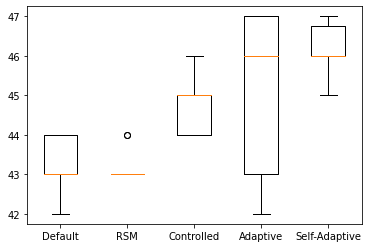

In [77]:
parameters = { 0 : ["a", "b", "c", "d"],
               1 : ["d", "e", "f", "g", "x"],
               2 : ["g", "h", "i"]}
num_tests = 20
configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2
results = {
    "Default"       : run_times(ga, configuration, 10),
    "RSM"           : run_times(ga, rsm_config, 10),
    "Controlled"    : run_times(controlled_ga, configuration, 10),
    "Adaptive"      : run_times(adaptive_ga, configuration, 10),
    "Self-Adaptive" : run_times(self_adaptive_ga, configuration, 10)
}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

[Text(1, 0, 'Default'),
 Text(2, 0, 'RSM'),
 Text(3, 0, 'Controlled'),
 Text(4, 0, 'Adaptive'),
 Text(5, 0, 'Self-Adaptive')]

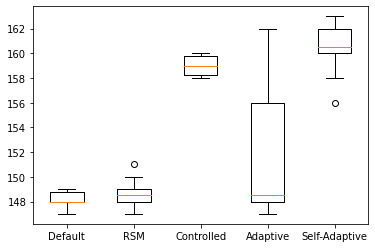

In [78]:
parameters = { 0 : ["a", "b", "c", "d", "e", "f", "g"],
               1 : ["d", "e", "f", "g", "x"],
               2 : ["d", "e", "f", "g"],
               3 : ["d", "e", "f"],
               4 : ["g", "h"]}
num_tests = 30
configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2
results = {
    "Default"       : run_times(ga, configuration, 10),
    "RSM"           : run_times(ga, rsm_config, 10),
    "Controlled"    : run_times(controlled_ga, configuration, 10),
    "Adaptive"      : run_times(adaptive_ga, configuration, 10),
    "Self-Adaptive" : run_times(self_adaptive_ga, configuration, 10)
}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

[Text(1, 0, 'Default'),
 Text(2, 0, 'RSM'),
 Text(3, 0, 'Controlled'),
 Text(4, 0, 'Adaptive'),
 Text(5, 0, 'Self-Adaptive')]

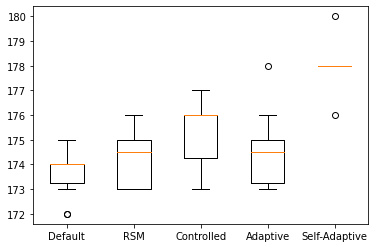

In [82]:
parameters = { 0 : ["0", "1"],
               1 : ["0", "1"],
               2 : ["0", "1"],
               3 : ["0", "1"],
               4 : ["0", "1"],
               5 : ["0", "1"],
               6 : ["0", "1"],
               7 : ["0", "1"],
               8 : ["0", "1"],
               9 : ["0", "1"]}
num_tests = 6 # 10 is required
configuration['P_xover'] = 0.7
configuration['P_mutation'] = 0.07
configuration['population_size'] = 100
configuration['tournament_size'] = 2
results = {
    "Default"       : run_times(ga, configuration, 10),
    "RSM"           : run_times(ga, rsm_config, 10),
    "Controlled"    : run_times(controlled_ga, configuration, 10),
    "Adaptive"      : run_times(adaptive_ga, configuration, 10),
    "Self-Adaptive" : run_times(self_adaptive_ga, configuration, 10)
}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

## Outlook: Hyper-Heuristics

In this chapter we considered how to tune and adjust the quantitative parameter values for a given search algorithm. However, sometimes different qualitative parameters (e.g., different types of mutation operators) may be beneficial at different times throughout the search, and sometimes even entirely different algorithms may perform better at different points during the search. Indeed there might not be a single optimal heuristic for a given problem type. The idea of _hyper heuristics_ is to apply different heuristics to different parts or phases of the solution process.
A hyper-heuristic is a search method for selecting or generating heuristics to solve computational search problems, and so it can, essentially, produce entirely new and adaptive meta-heuristic search algorithms.

An example for a hyper-heuristic application in software engineering can be found in the following article:

- Jia, Y., Cohen, M. B., Harman, M., & Petke, J. Learning combinatorial interaction test generation strategies using hyperheuristic search. In Proceedings of the 37th International Conference on Software Engineering-Volume 1 (pp. 540-550). IEEE Press, 2015

In this article, a selective hyper-heuristic is applied to combinatorial interaction testing, i.e. the example problem we used in this notebook. Simulated annealing is the central meta-heuristic, but six different neighbourhood exploration operators are defined, and reinforcement learning is applied in order to select which of them should be applied at each iteration of the simulated annealing algorithm.